In [1]:
from scipy import ndimage
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import xesmf as xe

In [2]:
def fill_missing_data_laplace(
    field: np.ndarray,
    mask: np.ndarray,
    periodic_lon: bool = True
) -> np.ndarray:
    """
    Fill nans smoothly by solving a discrete Laplace problem over the wet domain.

    This is adapted from https://github.com/ACCESS-NRI/om3-scripts/blob/main/chlorophyll/chl_climatology_and_fill.py,
    which originally adapted from https://github.com/adcroft/interp_and_fill/blob/main/Interpolate%20and%20fill%20SeaWIFS.ipynb

    This implementation otherwise assumes a regular lat/lon grid tri-polar (WOA),
    hence tripolar topology is intentionally not handled here.

    Periodic boundary conditions are supported in longitude only (global configuration).
    For regional configurations, set periodic_lon=False is not implemented yet.
    """
    nj, ni = field.shape
    # Find the missing points to fill (nan in field but mask > 0)
    missing_mask = np.isnan(field) & (mask > 0)
    if not np.any(missing_mask):
        # no missing data to fill but also guarantee nans on dry cells
        return np.where(mask > 0, field, np.nan)

    # change nan to 0 for the sparse matrix construction
    work = np.where(np.isnan(field), 0.0, field)
    missing_j, missing_i = np.where(missing_mask)
    n_missing = missing_j.size
    ind = np.full((nj, ni), -1, dtype=np.int64)
    ind[missing_j, missing_i] = np.arange(n_missing)

    # Sparse matrix
    A = sp.lil_matrix((n_missing, n_missing))
    b = np.zeros(n_missing)
    ld = np.zeros(n_missing)

    def _process_neighbour(n: int, jn: int, in_: int) -> None:
        """Process neighbour at (jn, in_) for row n."""
        if mask[jn, in_] <= 0:
            return

        ld[n] -= 1
        idx = ind[jn, in_]

        if idx >= 0:
            A[n, idx] = 1
        else:
            b[n] -= work[jn, in_]

    for n in range(n_missing):
        j = missing_j[n]
        i = missing_i[n]

        if periodic_lon:
            im1 = (i - 1) % ni  # west
            ip1 = (i + 1) % ni  # east
            _process_neighbour(n, j, im1)
            _process_neighbour(n, j, ip1)
        else:
            # TODO handle non-periodic case if needed
            raise NotImplementedError(
                "Non-periodic longitude is not implemented yet. "
                "Set periodic_lon=True for global grids."
            )

        if j > 0:
            _process_neighbour(n, j - 1, i)  # south
        if j < nj - 1:
            _process_neighbour(n, j + 1, i)  # north

    stabilizer = 1e-14  # prevent singular matrix
    A[np.arange(n_missing), np.arange(n_missing)] = ld - stabilizer
    x = spla.spsolve(A.tocsr(), b)
    work[missing_j, missing_i] = x
    work = np.where(mask > 0, work, np.nan)
    return work


def laplace_smooth_with_dilation(field: np.ndarray, mask: np.ndarray, expand_iters: int = 2) -> np.ndarray:
    """
    Smooth field over wet cells only by applying a Laplace smoother iteratively.
    stage1: Fill missing values over the original wet mask using a Laplacian solver.
            This ensures coastal nans gets filled and the field is continuous across the entire ocean domain.
    stage2: Dilate the wet mask inward by `expand_iters` number of grid cells, and apply the
            Laplacian solver again over this reduced (interior) region. This step smooths the interior.

    expand_iters: Number of grid cells by which to shrink the wet mask before the 2nd smoothing stage.
                   Larger values reduce coastal influence more strongly.
    """
    wet = mask > 0
    stage1 = fill_missing_data_laplace(field, mask=wet, periodic_lon=True)

    if expand_iters <= 0:
        return np.where(wet, stage1, np.nan)

    wet_expanded = ndimage.binary_dilation(wet, iterations=expand_iters)

    stage2_interior = fill_missing_data_laplace(stage1, mask=wet_expanded, periodic_lon=True)

    return np.where(wet, stage2_interior, np.nan)

In [3]:
woa_result = "/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/external_tidal_generation/WOA_based_output_update5.nc"
woa_result = xr.open_dataset(woa_result)

# `laplace_smooth_with_dilation` or `fill_missing_data_laplace` applies to **WOA** depth_var
The initial attempt applied `laplace_smooth_with_dilation` or `fill_missing_data_laplace` directly on the WOA `depth_var` to remove coastal nans prior to regridding, but as Andrew Kiss pointed out in https://github.com/ACCESS-NRI/om3-scripts/pull/105#discussion_r2831690491
> Hmm, that's what I thought, but I'm not sure that's what we want, since the land mask in the intermediate file will differ from the land mask in the model.
> 
> If we have dry cells in the intermediate file which are wet in the model, what values will the model get in those wet cells?
> 
> For the initial condition files we deal with this issue by horizontally extrapolating WOA data throughout the dry cells, so we have data for every wet cell in the model, regardless of what land mask it has.

This clearly highlights that filling only woa ocean region based on its own mask does not guarentee that every MOM wet cell will receive a valid value after regridding. Mask mismatches between woa and the model grid can lead to cases where a mom6 wet cell depends on woa cells that remain nans in the intermediate file.

Below plots however correspond to this first approach to demonstrate that `fill_missing_data_laplace` works as expected - **smoothly fills nans within specified wet domain and produces a continuous coastal field**. *However this approach was not adopted in the final implementation cuz it does not explicitly account for the regridding weights or the model land mask.*

**In the final version**, this `fill_missing_data_laplace` is instead applied in the regridding script (`generate_bottom_roughness_regrid.py`) after constructing the esmf regridder. We compute which woa source cells are actually required by the regridding weights for mom6 wet cells, and then expand the fill mask accordingly. So it ensures,

- every mom6 wet cell receives valid input data.
- filling is driven by the actual regridding stencil
- no unnecessary exptrapolation is performed beyond what is required by the weights.


In [4]:
da = woa_result.depth_var
mask_da = (woa_result.lambda1 > 0)

nan_on_wet = da.isnull() & mask_da
n_wet = int(mask_da.sum().values)
n_nan_wet = int(nan_on_wet.sum().values)

print("n_wet =", n_wet)
print("n_nan_wet =", n_nan_wet)

depth_var_filled_np1_1 = laplace_smooth_with_dilation(da.values, mask_da.values, expand_iters=-1)
depth_var_filled_np1_2 = laplace_smooth_with_dilation(da.values, mask_da.values, expand_iters=2)

depth_var_filled = xr.DataArray(
    depth_var_filled_np1_1,
    dims=da.dims,
    coords=da.coords,
    name="depth_var_filled_un-dilation",
)

n_wet = 677127
n_nan_wet = 1323


# Check if stage2 (wet mask dilation) is necessary -> no, results are identical

In [5]:
are_identical = np.allclose(
    da.values,
    depth_var_filled_np1_1,
    equal_nan=True,
    atol=1e-20,
    rtol=1e-20
)
print("Identical between unfilled and filled", are_identical)

are_identical = np.allclose(
    depth_var_filled_np1_1,
    depth_var_filled_np1_2,
    equal_nan=True,
    atol=1e-20,
    rtol=1e-20
)
print("Identical between un-dilation and dilation", are_identical)

Identical between unfilled and filled False
Identical between un-dilation and dilation True


In [6]:
regions = [
    (-180, 180, -90, 90),  # global
    (-80, -40, 30, 60),
    (0, 40, -71, -50),
    (100, 140, 10, 40),
]

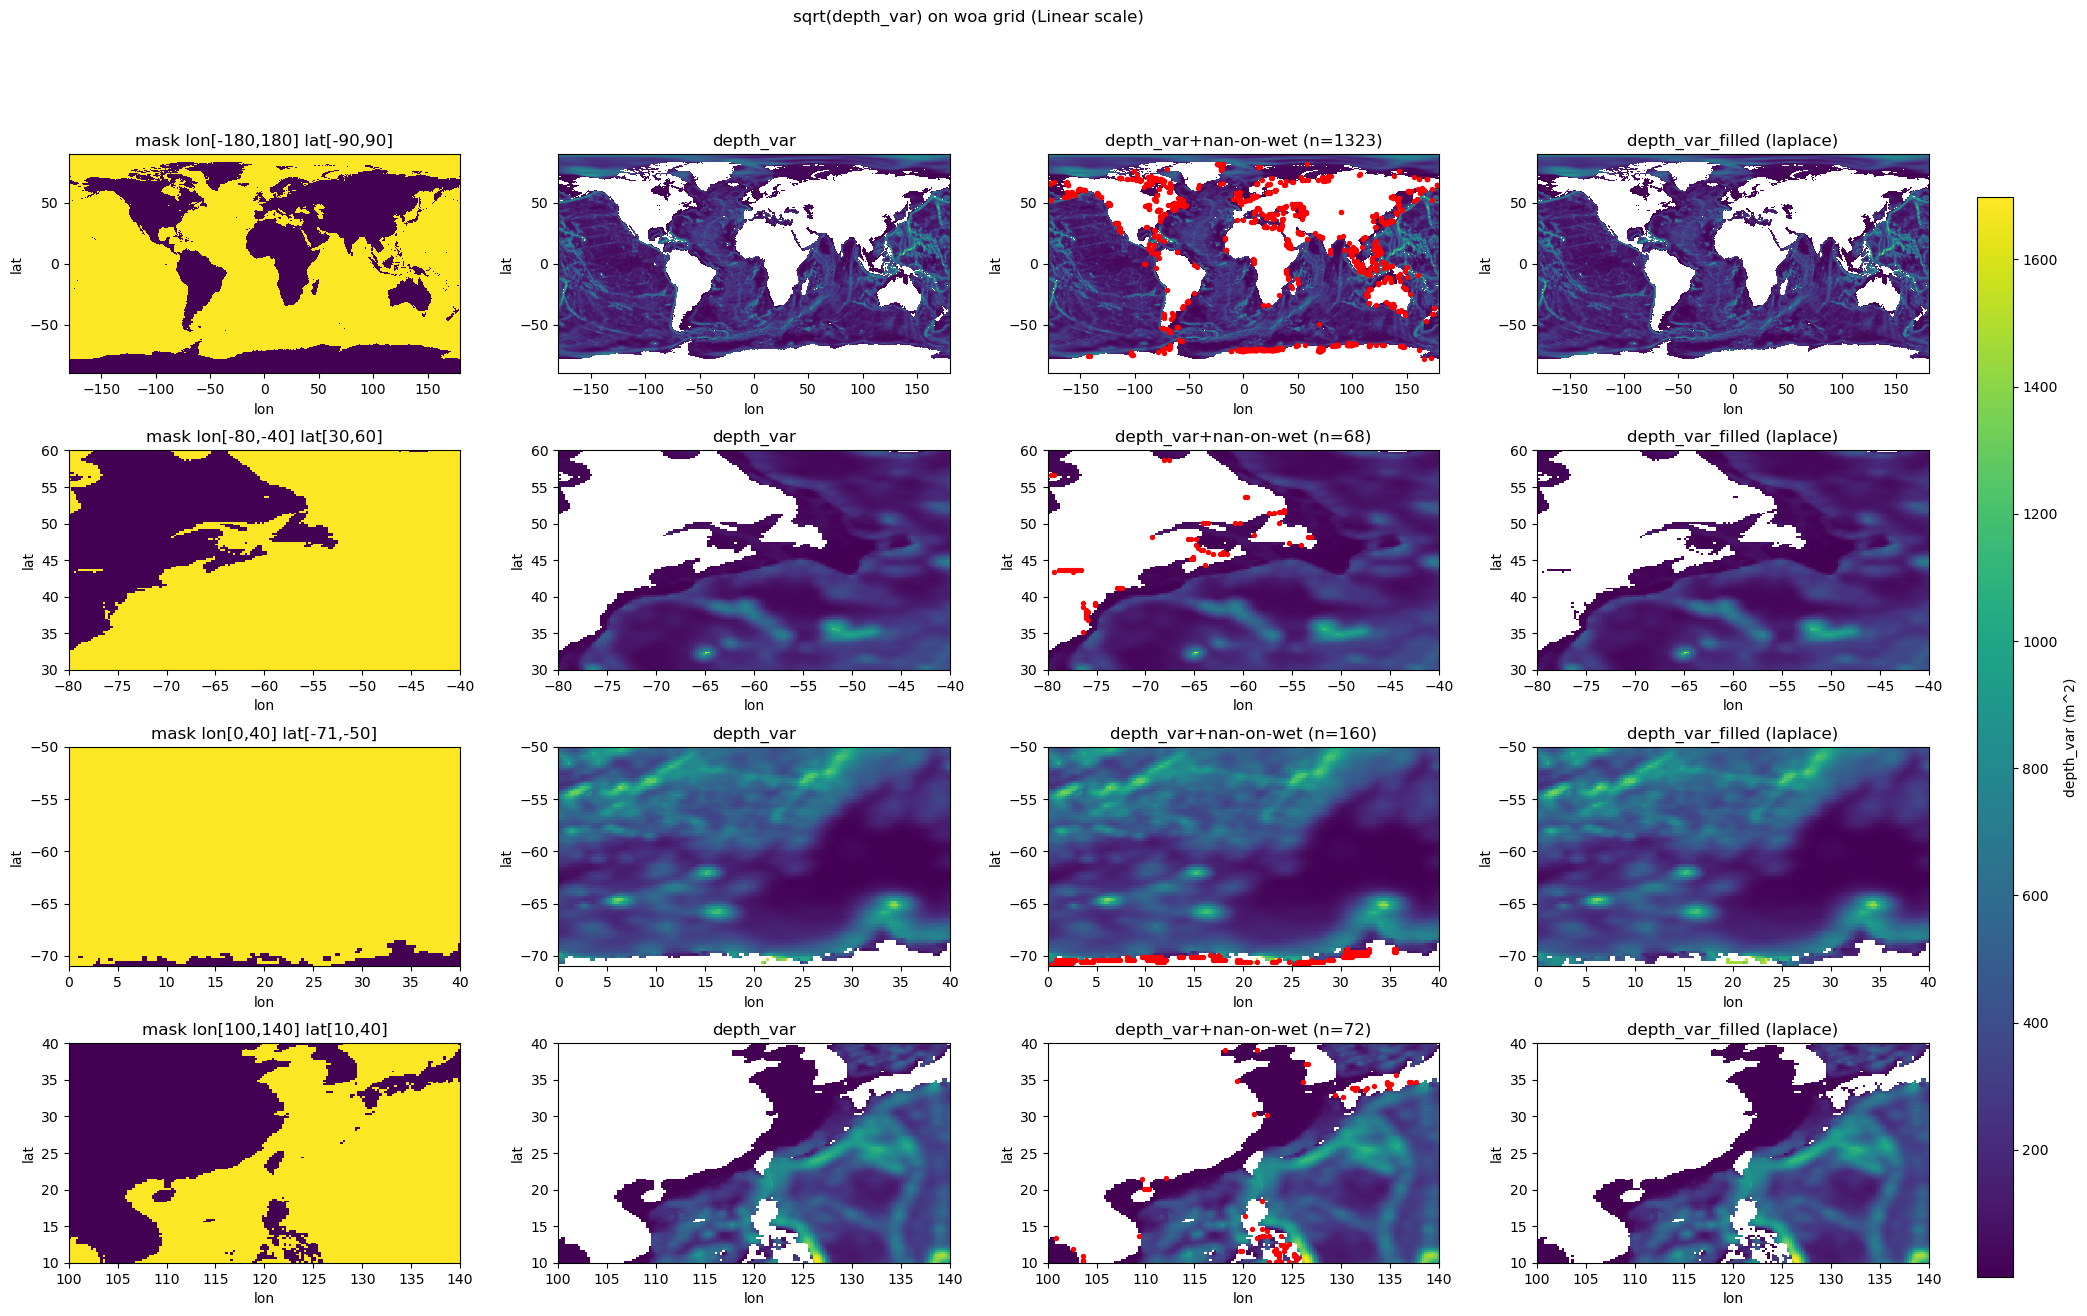

In [7]:
nrows = len(regions)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), constrained_layout=False)

last_pcm_field = None
last_pcm_filled = None

for r, (lon_min, lon_max, lat_min, lat_max) in enumerate(regions):
    sel_kwargs = dict(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    da_zoom = da.sel(**sel_kwargs)
    mask_zoom = mask_da.sel(**sel_kwargs)
    nan_zoom = (da_zoom.isnull() & mask_zoom).values

    filled_zoom = depth_var_filled.sel(**sel_kwargs)

    lon = da_zoom["lon"].values
    lat = da_zoom["lat"].values

    # indices of nan-on-wet
    jj, ii = np.where(nan_zoom)

    ax = axes[r, 0]
    pcm0 = ax.pcolormesh(lon, lat, mask_zoom.values.astype(int))
    ax.set_title(f"mask lon[{lon_min},{lon_max}] lat[{lat_min},{lat_max}]")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 1]
    last_pcm_field = ax.pcolormesh(lon, lat, np.sqrt(da_zoom.values))
    ax.set_title("depth_var")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 2]
    ax.pcolormesh(lon, lat, np.sqrt(da_zoom.values))
    if jj.size:
        ax.scatter(lon[ii], lat[jj], s=8, c="r")
    ax.set_title(f"depth_var+nan-on-wet (n={jj.size})")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 3]
    last_pcm_filled = ax.pcolormesh(lon, lat, np.sqrt(filled_zoom.values))
    ax.set_title("depth_var_filled (laplace)")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

fig.subplots_adjust(right=0.90, wspace=0.25, hspace=0.35)
fig.suptitle("sqrt(depth_var) on woa grid (Linear scale)")

cax1 = fig.add_axes([0.92, 0.1, 0.015, 0.75])
fig.colorbar(last_pcm_field, cax=cax1, label="depth_var (m^2)")

plt.show()

0.007206316284100068 2031.3389042768492


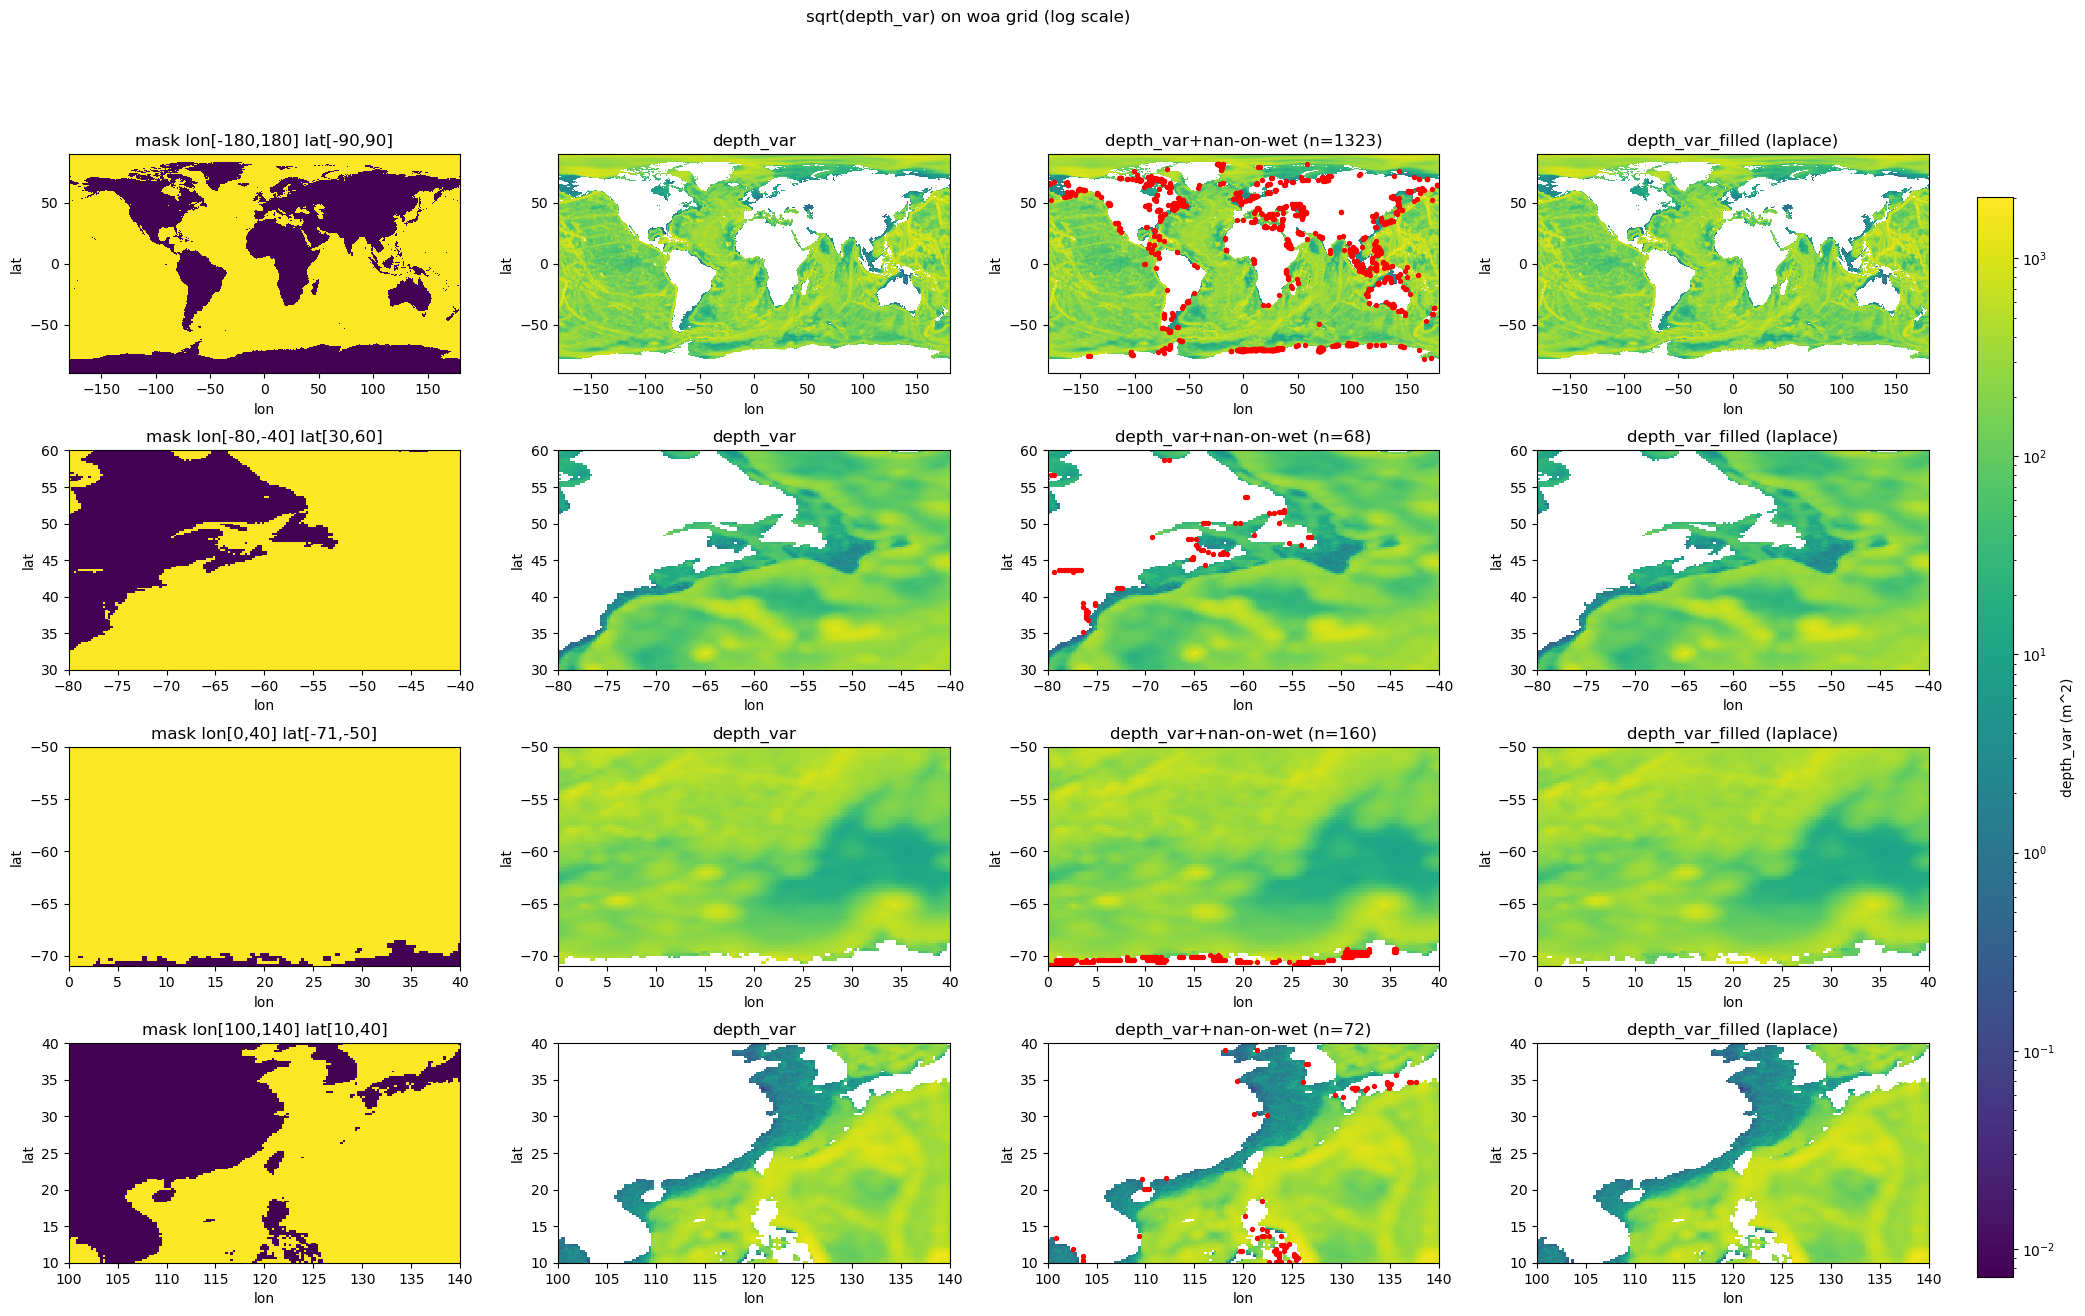

In [8]:
vmin = float(np.nanmin(np.sqrt(da.where(da > 0))))
vmax = float(np.nanmax(np.sqrt(da)))

print(vmin, vmax)

nrows = len(regions)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), constrained_layout=False)

last_pcm_field = None
last_pcm_filled = None

for r, (lon_min, lon_max, lat_min, lat_max) in enumerate(regions):
    sel_kwargs = dict(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    da_zoom = da.sel(**sel_kwargs)
    mask_zoom = mask_da.sel(**sel_kwargs)
    nan_zoom = (da_zoom.isnull() & mask_zoom).values

    filled_zoom = depth_var_filled.sel(**sel_kwargs)

    lon = da_zoom["lon"].values
    lat = da_zoom["lat"].values

    # indices of nan-on-wet
    jj, ii = np.where(nan_zoom)

    ax = axes[r, 0]
    pcm0 = ax.pcolormesh(lon, lat, mask_zoom.values.astype(int))
    ax.set_title(f"mask lon[{lon_min},{lon_max}] lat[{lat_min},{lat_max}]")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 1]
    last_pcm_field = ax.pcolormesh(lon, lat, np.sqrt(da_zoom.values), norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_title("depth_var")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 2]
    ax.pcolormesh(lon, lat, np.sqrt(da_zoom.values), norm=LogNorm(vmin=vmin, vmax=vmax))
    if jj.size:
        ax.scatter(lon[ii], lat[jj], s=8, c="r")
    ax.set_title(f"depth_var+nan-on-wet (n={jj.size})")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 3]
    last_pcm_filled = ax.pcolormesh(lon, lat, np.sqrt(filled_zoom.values), norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_title("depth_var_filled (laplace)")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

fig.subplots_adjust(right=0.90, wspace=0.25, hspace=0.35)
fig.suptitle("sqrt(depth_var) on woa grid (log scale)")

cax1 = fig.add_axes([0.92, 0.1, 0.015, 0.75])
fig.colorbar(last_pcm_field, cax=cax1, label="depth_var (m^2)")

plt.show()

# Check values of differences for the last row above

In [9]:
A = np.sqrt(da_zoom.values)
B = np.sqrt(filled_zoom.values)

equal = ((np.isfinite(A) & np.isfinite(B) & np.isclose(A, B, rtol=1e-12, atol=1e-14))| (np.isnan(A) & np.isnan(B)))
not_equal = ~equal
jj, ii = np.where(not_equal)
print(f"num of mismatched points: {jj.size}")
for j, i in zip(jj, ii):
    print(
        f"lon={lon[i]:.8f}, lat={lat[j]:.8f}, "
        f"A={A[j, i]}, B={B[j, i]}"
    )

num of mismatched points: 72
lon=103.62500000, lat=10.12500000, A=nan, B=0.18206998093771384
lon=122.62500000, lat=10.12500000, A=nan, B=856.8280439668557
lon=123.37500000, lat=10.12500000, A=nan, B=-0.0
lon=123.87500000, lat=10.12500000, A=nan, B=-0.0
lon=124.62500000, lat=10.12500000, A=nan, B=208.50776155813682
lon=103.62500000, lat=10.37500000, A=nan, B=0.18206998093771293
lon=125.37500000, lat=10.37500000, A=nan, B=421.80260950128695
lon=123.62500000, lat=10.62500000, A=nan, B=-0.0
lon=125.37500000, lat=10.62500000, A=nan, B=371.1011041911514
lon=125.62500000, lat=10.62500000, A=nan, B=312.27330606648735
lon=103.62500000, lat=10.87500000, A=nan, B=-0.0
lon=123.62500000, lat=10.87500000, A=nan, B=-0.0
lon=125.12500000, lat=10.87500000, A=nan, B=371.10110419114204
lon=125.37500000, lat=10.87500000, A=nan, B=371.1011041911458
lon=123.37500000, lat=11.12500000, A=nan, B=-0.0
lon=123.62500000, lat=11.12500000, A=nan, B=-0.0
lon=125.12500000, lat=11.12500000, A=nan, B=371.10110419114017

# Below shows what has been implemented in the final version

## Load depth_var after regridding

In [10]:
tmp_25km_first = xr.open_dataset("/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/external_tidal_generation/bottom_roughness_25km_old.nc")
tmp_25km_revise = xr.open_dataset("/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/external_tidal_generation/bottom_roughness_25km_final_version_5.nc")

## Create 25km model mask da

In [11]:
TOPOG_PATH="/g/data/vk83/configurations/inputs/access-om3/share/grids/global.25km/2025.11.27/topog.nc"
topog = xr.open_dataset(TOPOG_PATH)

def mom6_mask_detection(ds, minimum_depth=None, masking_depth=None):
    """
    Detect and generate an ocean mask (1 = wet, 0 = land) from a topog.nc.
    https://github.com/ACCESS-NRI/MOM6/blob/569ba3126835bfcdea5e39c46eeae01938f5413c/src/initialization/MOM_grid_initialize.F90#L1180
    """

    if "depth" not in ds:
        raise ValueError("Cannot detect topog: dataset lacks 'depth' variable!")

    depth = ds["depth"]

    # topog contains nans
    is_wet = ~np.isnan(depth)

    if masking_depth is None and minimum_depth is None:
        mask = is_wet
    elif masking_depth is None:
        mask = (depth > minimum_depth) & is_wet
    elif minimum_depth is None:
        mask = (depth > masking_depth) & is_wet
    else:
        if masking_depth > minimum_depth:
            raise ValueError(
                "MASKING_DEPTH must be less than or equal to MINIMUM_DEPTH!"
            )
        mask = (depth > masking_depth) & is_wet

    return mask.astype(np.int8).values

mask = mom6_mask_detection(topog)
mask = xr.DataArray(
    mask,
    dims=("y", "x"),
    coords={
        "lon": tmp_25km_first["lon"],
        "lat": tmp_25km_first["lat"],
    },
    name="mask"
)
mask

<xarray.DataArray 'mask' (y: 1152, x: 1440)> Size: 2MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)
Coordinates:
    lon      (y, x) float64 13MB ...
    lat      (y, x) float64 13MB ...
Dimensions without coordinates: y, x

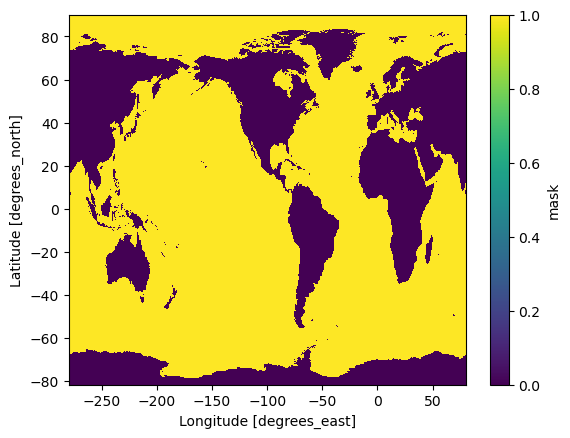

In [12]:
mask.plot(x="lon", y="lat")

# Check nans before and after
So one can see the initial result from [9e69b44](https://github.com/ACCESS-NRI/om3-scripts/blob/9e69b448259fb0cdfb770f30d6a960c732817e7b/external_tidal_generation/generate_bottom_roughness_regrid.py) contains more nans (**23988**) than the most recent updated result

In [13]:
da1 = np.sqrt(tmp_25km_first["h2"])
da2 = np.sqrt(tmp_25km_revise["h2"])

nan1 = np.isnan(da1)
nan2 = np.isnan(da2)

print("nan masks identical:", bool((nan1 == nan2).all()))
print("nan only in da1:", int((nan1 & ~nan2).sum()))
print("nan only in da2:", int((nan2 & ~nan1).sum()))

nan masks identical: False
nan only in da1: 23988
nan only in da2: 0


## Compare common finite cells

cells compared  962083
max abs diff  0.0


/jobfs/161341265.gadi-pbs/ipykernel_2001231/2030982481.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  a = plt.pcolormesh(da1.lon, da1.lat, nan_in_da1_only.astype(int))


Text(0.5, 1.0, 'Cells where initial is nan but revised is finite')

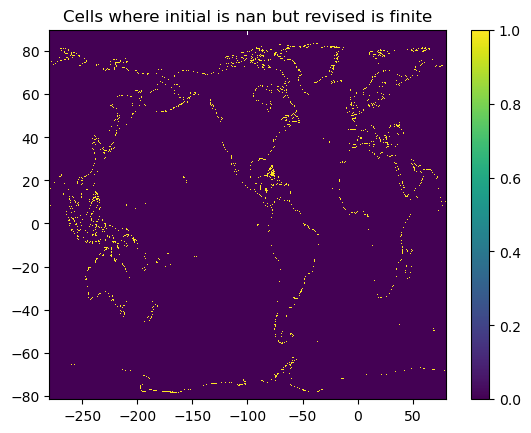

In [14]:
da1a, da2a = xr.align(da1, da2, join="inner")
valid = np.isfinite(da1a) & np.isfinite(da2a)
diff = (da2a - da1a).where(valid)

print("cells compared ", int(valid.sum()))
print("max abs diff ", float(np.abs(diff).max(skipna=True)))

nan_in_da1_only = da1.isnull() & da2.notnull()
a = plt.pcolormesh(da1.lon, da1.lat, nan_in_da1_only.astype(int))
plt.colorbar(a)
plt.title("Cells where initial is nan but revised is finite")

/jobfs/161341265.gadi-pbs/ipykernel_2001231/1758710337.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = axes[i,0].pcolormesh(
/jobfs/161341265.gadi-pbs/ipykernel_2001231/1758710337.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = axes[i,1].pcolormesh(
/jobfs/161341265.gadi-pbs/ipykernel_2001231/1758710337.py:45: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im

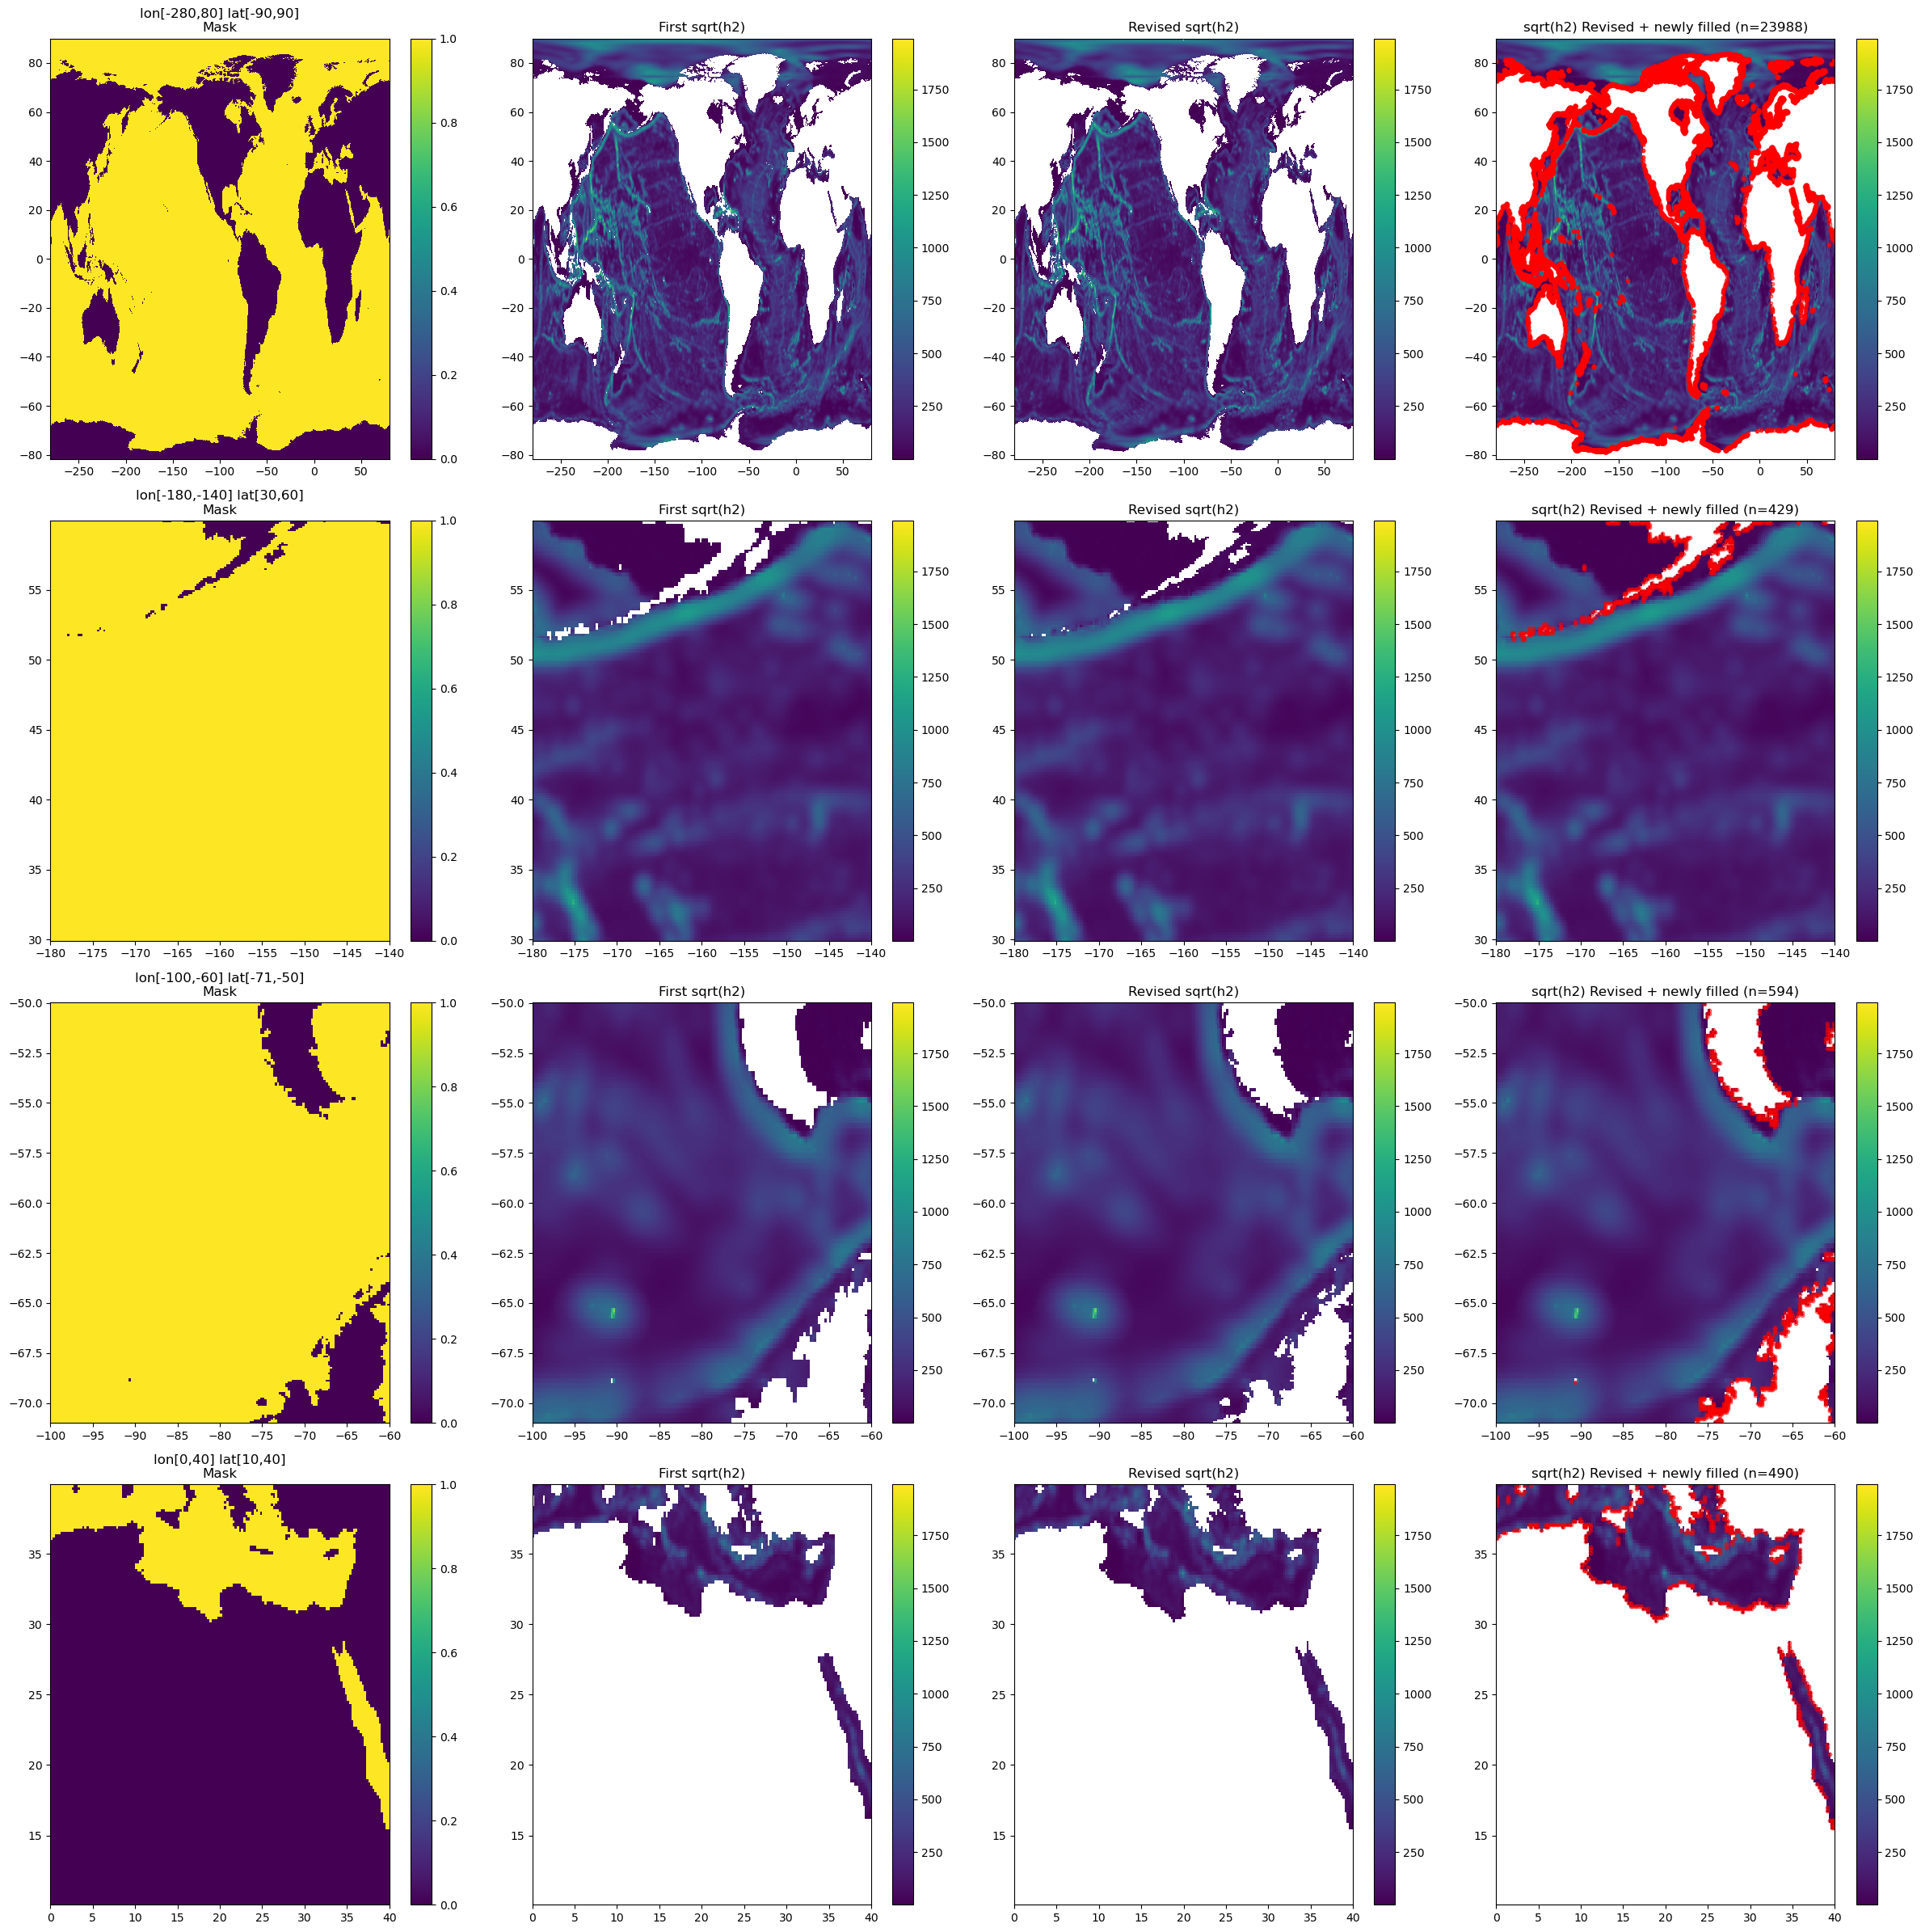

In [15]:
regions = [
    (-280, 80, -90, 90),  # global
    (-180, -140, 30, 60),
    (-100, -60, -71, -50),
    (0, 40, 10, 40),
]

def subset_region(da, lonmin, lonmax, latmin, latmax):
    return da.where(
        (da.lon >= lonmin) &
        (da.lon <= lonmax) &
        (da.lat >= latmin) &
        (da.lat <= latmax),
        drop=True
    )

n_rows = len(regions)
fig, axes = plt.subplots(n_rows, 4, figsize=(24, 6*n_rows))

vmin = float(np.nanmin([da1.min(), da2.min()]))
vmax = float(np.nanmax([da1.max(), da2.max()]))

for i, (lonmin, lonmax, latmin, latmax) in enumerate(regions):

    da0_sub = subset_region(mask, lonmin, lonmax, latmin, latmax)
    da1_sub = subset_region(da1, lonmin, lonmax, latmin, latmax)
    da2_sub = subset_region(da2, lonmin, lonmax, latmin, latmax)

    label = f"lon[{lonmin},{lonmax}] lat[{latmin},{latmax}]"

    im0 = axes[i,0].pcolormesh(
        da0_sub.lon, da0_sub.lat, da0_sub,
        shading="auto"
    )
    axes[i,0].set_title(f"{label}\nMask")
    plt.colorbar(im0, ax=axes[i,0])

    im1 = axes[i,1].pcolormesh(
        da1_sub.lon, da1_sub.lat, da1_sub,
        shading="auto", vmin=vmin, vmax=vmax
    )
    axes[i,1].set_title("First sqrt(h2)")
    plt.colorbar(im1, ax=axes[i,1])

    im2 = axes[i,2].pcolormesh(
        da2_sub.lon, da2_sub.lat, da2_sub,
        shading="auto", vmin=vmin, vmax=vmax
    )
    axes[i,2].set_title("Revised sqrt(h2)")
    plt.colorbar(im2, ax=axes[i,2])

    im3 = axes[i,3].pcolormesh(
        da2_sub.lon, da2_sub.lat, da2_sub,
        shading="auto", vmin=vmin, vmax=vmax
    )

    newly_filled = da1_sub.isnull() & da2_sub.notnull()
    jj, ii = np.where(newly_filled.values)

    lon_plot = da2_sub["lon"].values
    lat_plot = da2_sub["lat"].values
    
    if jj.size > 0:
        axes[i,3].scatter(lon_plot[jj, ii], lat_plot[jj, ii], s=10, c="red", alpha=0.5)

    axes[i,3].set_title(f"sqrt(h2) Revised + newly filled (n={jj.size})")
    plt.colorbar(im3, ax=axes[i,3])

plt.tight_layout()
plt.show()

In [16]:
A = np.sqrt(da1_sub.values)
B = np.sqrt(da2_sub.values)

equal = ((np.isfinite(A) & np.isfinite(B) & np.isclose(A, B, rtol=1e-12, atol=1e-14))| (np.isnan(A) & np.isnan(B)))
not_equal = ~equal
jj, ii = np.where(not_equal)

n_total = jj.size
n_show = min(20, n_total)

print(f"num of mismatched points: {n_total}")
print(f"showing first {n_show}")

for j, i in zip(jj[:n_show], ii[:n_show]):
    print(
        f"lon={lon[i]:.3f}, lat={lat[j]:.3f}, "
        f"Old={A[j, i]}, Revised={B[j, i]}"
    )

num of mismatched points: 490
showing first 20
lon=139.625, lat=15.625, Old=nan, Revised=3.126278375168083
lon=139.875, lat=15.625, Old=nan, Revised=3.141462888640463
lon=139.625, lat=15.875, Old=nan, Revised=3.0499086654837004
lon=139.875, lat=15.875, Old=nan, Revised=2.903778110529996
lon=139.375, lat=16.125, Old=nan, Revised=3.180627054103883
lon=139.625, lat=16.125, Old=nan, Revised=3.0338820487233114
lon=139.875, lat=16.125, Old=nan, Revised=2.4453570518649994
lon=139.125, lat=16.875, Old=nan, Revised=9.630353762581013
lon=139.125, lat=17.125, Old=nan, Revised=10.547962440785028
lon=138.875, lat=17.875, Old=nan, Revised=10.352377180182291
lon=138.625, lat=18.125, Old=nan, Revised=9.692196084817944
lon=138.375, lat=18.375, Old=nan, Revised=8.53088430736977
lon=138.125, lat=18.625, Old=nan, Revised=6.756865628965675
lon=138.375, lat=18.625, Old=nan, Revised=8.1319263712477
lon=137.875, lat=18.875, Old=nan, Revised=2.663888277261271
lon=137.375, lat=19.375, Old=nan, Revised=13.494279